# In this notebook we plan the fix-priority path for two agents on the hybrid graph and animate the result.

In [1]:
import sys
sys.path.append('../../')
from panav.env import NavigationEnv, Box2DRegion, box_2d_center
from panav.hybrid import HybridGraph
from panav.viz import draw_env,draw_hybrid

import networkx as nx
import numpy as np
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

## Single-tunnel environment

In [223]:


# 2D navigation environment
start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])


start_locs = np.array([[5,1],[-5,-1]])*1.5

goal_locs = np.array([[-5,1],[5,-1]])*1.5



starts = [box_2d_center(s,start_box_side) for s in start_locs]
goals = [box_2d_center(g,goal_box_side) for g in goal_locs]
limits = [(-10.0,10.0),(-10.0,10.0)]


# O1 = Box2DRegion((-5.0,-0.5),(0.5,10))
# O2 = Box2DRegion((-0.0,5.0),(-10,-1.0))
# env = NavigationEnv(limits,[O1,O2],starts,goals)


O1 = Box2DRegion((-2.5,2.5),(0.5,10))
O2 = Box2DRegion((-2.5,2.5),(-10,-1.0))
env = NavigationEnv(limits,[O1,O2],starts,goals)


# O1 = Box2DRegion((-2.5,2.5),(0.5,10))
# O2 = Box2DRegion((-2.5,2.5),(-3,-1.0))
# O3 = Box2DRegion((-2.5,2.5),(-10.0,-4.0))
# env = NavigationEnv(limits,[O1,O2,O3],starts,goals)


# Construct the hybrid graph representation of the environment
bloating_r = 0.5 
HG =  HybridGraph(env,bloating_r)


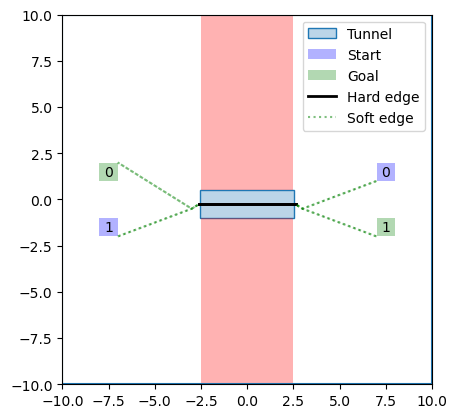

In [224]:
ax = plt.gca()
draw_hybrid(HG,ax)
plt.show()    

In [225]:
from panav.SIPP import SIPP, compute_safe_intervals, plan_to_transitions
go_agent = 0
go_plan = SIPP(HG,HG.node_locs(),HG.start_nodes[go_agent],HG.goal_nodes[go_agent],[],HG.vmax,HG.agent_radius)

In [226]:
def graph_plan_to_continuous(go_plan,HG):
    graph_trans= plan_to_transitions(go_plan)
    full_time = [0]
    full_path = [HG.node_loc(go_plan[0][0])[:,np.newaxis]]
    for u,v,t0,t1 in graph_trans[:-1]:
       
        if u==v:
            if t1-t0>1e-2:
                full_time.append(t1)
                full_path.append(full_path[-1][:,-1][:,np.newaxis])
        else:
            full_time.extend(list(HG.edges[u,v]['continuous_time'][1:]+full_time[-1]))
            full_path.append(HG.edges[u,v]['continuous_path'][:,1:])

    return np.array(full_time),np.hstack(full_path)

In [230]:
from copy import deepcopy
t,x = graph_plan_to_continuous(go_plan, HG)

In [235]:
from panav.HybridSIPP import HybridSIPP
yield_agent = 1
g_plan,c_plan = HybridSIPP(HG,HG.node_locs(),HG.start_nodes[yield_agent],HG.goal_nodes[yield_agent],
           plan_to_transitions(go_plan),[(t,x)],
           HG.vmax,HG.agent_radius)

In [239]:
from panav.viz import animation,interpolate_positions

from IPython.display import HTML, display
interp_dt = 0.1

times,xs = interpolate_positions(t,x,interp_dt)
t2,x2 = interpolate_positions(*c_plan,interp_dt)

pos = [xs,x2]

anim = animation(env, pos, bloating_r, dt = interp_dt / 4)
display(HTML(anim.to_jshtml()))
plt.close()   # Avoid plotting an extra figure.